# Semantic Plagiarism Detection of Bangla: Paraphrase Generation and Sentence Embedding using Language Model


# Abstract
Bangla, the seventh most spoken language in the world, remains underrepresented in the development of advanced NLP tools. Plagiarism detection is especially critical in low-resource languages like Bangla, where traditional plagiarism detection tools often fail to detect complex paraphrasing and semantic similarity. To address this, I have proposed a hybrid approach for semantic plagiarism detection in Bangla by combining paraphrase generation and sentence embedding using Large Language Models (LLMs). Models such as BanglaT5, and multilingual versions of BART are employed for paraphrasing. To measure semantic similarity between original and paraphrased texts, I have used Bangla-BERT. Evaluation metrics including F1-score ans BERTScore are used to assess performance. My findings shows that Bangla-T5 performed good than mBART in different threshold. 



## Research Question
How effective is the combination of mBART-based paraphrase generation and sentence embedding techniques in detecting semantic plagiarism in Bangla text?

# Methodology

In this project for detecting semantic plagiarism using a hybrid approach. The first part involves paraphrasing, and the second part focuses on sentence embedding. 
First, I have started with a pair of sentences to check for potential plagiarism. Than, the input sentences transforms the original sentence (S1) into multiple paraphrases (S1_P1, S1_P2, S1_P3, ..., S1_PN) using language models like Bangla-T5 and mBART. 
Secondly, sentences are turned into vector embeddings using models like Bangla-BERT. I have computed a semantic similarity score between the original and its paraphrase. If this score exceeds a chosen threshold(0.55-0.85), flag it as potential plagiarism. Finally, these similarity scores are used to assess how likely the text contains plagiarized content.

# Required Dependencies
Though I have included the full environment.yml file, where all the necessary dependencies are mentioned for this project. Here also mentioned all install required libraries if not already installed.

In [16]:
!pip install transformers bert-score rouge-score indic-nlp-library nltk

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [17]:
# All Imports are here
from transformers import MBartTokenizer, MBartForConditionalGeneration, BartTokenizer, BartForConditionalGeneration
from indicnlp.tokenize.sentence_tokenize import sentence_split
from bert_score import score as bertscore_score
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from torch.nn.functional import cosine_similarity
import torch
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ayeshakhatun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Dataset
Dataset download from Hugging Face, this dataset contains Bangla sentence pairs labelled as paraphrases or non-paraphrases, which is essential for detecting semantic plagiarism. It contains 8,787 human-annotated sentence pairs collected from a total of 23 newspaper outlets headlines on four categories. In this project I have used only there test data. link: https://huggingface.co/datasets/bracealround/BnPC-A-Gold-Standard-Bangla-Paraphrase-Corpus

In [18]:
from dataset import dataset

In [19]:
# preprocessing the text
def preprocess_text(text):
    return sentence_split(text, lang='bn')

## Analysis 01: Generate Paraphrase using mBART
This code loads a pre-trained model (mBART) and its tokenizer, which can generate paraphrases of input text. It sets the language to Bangla and defines a function that takes a sentence, prepares it for the model, and then generates a paraphrase using LLMs. The function returns the paraphrased sentence. The model uses beam search and returns the best paraphrase based on the input text.

In [20]:
from transformers import MBartForConditionalGeneration, MBart50Tokenizer

# Load model and tokenizer correctly
model_name = 'facebook/mbart-large-50-many-to-many-mmt'
tokenizer = MBart50Tokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)

# Set language codes properly
tokenizer.src_lang = "bn_IN"
forced_bos_token_id = tokenizer.lang_code_to_id["bn_IN"]

# Paraphrasing Function
def generate_paraphrase(text):
    input_text = f"paraphrase: {text}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(**inputs, max_length=512, num_beams=5, num_return_sequences=1,
                             early_stopping=True, forced_bos_token_id=forced_bos_token_id)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

## Compute Similarity & Metrics
This code uses the BART model to calculate the similarity between two sentences by converting them into embeddings. It then computes the cosine similarity between these embeddings to determine how similar the sentences are.

In [21]:
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

def calculate_bart_score(t1, t2):
    i1 = bart_tokenizer(t1, return_tensors='pt', max_length=1024, truncation=True, padding='max_length')
    i2 = bart_tokenizer(t2, return_tensors='pt', max_length=1024, truncation=True, padding='max_length')
    with torch.no_grad():
        e1 = bart_model.model.encoder(**i1).last_hidden_state.mean(1)
        e2 = bart_model.model.encoder(**i2).last_hidden_state.mean(1)
    return cosine_similarity(e1, e2).item()

Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at facebook/bart-large-cnn and are newly initialized: ['model.shared.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Evaluate the System for mBART
This code evaluates the similarity between sentence pairs by generating paraphrases and calculating various similarity scores (BERT, ROUGE, BLEU, and BART). It computes accuracy, precision, recall, and F1 score, though I have used only F1 score and BERT score for comparison. 

In [22]:
def evaluate(dataset, threshold=0.65):
    from random import sample
    tp = fp = fn = tn = correct = 0
    berts, rouges, bleus, barts = [], [], [], []
    sample_data = sample(dataset, 10)
    for s1, s2, label in sample_data:
        p1 = preprocess_text(s1)[0]
        p2 = preprocess_text(s2)[0]
        para = generate_paraphrase(p1)
        sim_score = calculate_bart_score(para, p2)
        pred = int(sim_score > threshold)
        if pred == label: correct += 1
        if pred == 1 and label == 1: tp += 1
        if pred == 1 and label == 0: fp += 1
        if pred == 0 and label == 1: fn += 1
        if pred == 0 and label == 0: tn += 1
        berts.append(bertscore_score([para], [p2], lang='en')[2].mean().item())
        rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        rouges.append(rouge.score(para, p2)['rougeL'].fmeasure)
        bleus.append(sentence_bleu([word_tokenize(p2)], word_tokenize(para)))
        barts.append(sim_score)
        print(f"\nOriginal: {s1}\nTarget: {s2}\nParaphrased: {para}\nSimilarity: {sim_score:.2f} | Label: {label} | Predicted: {pred}")
    acc = correct / len(sample_data)
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    print(f"\n✅ Accuracy: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")
    print(f"📊 Avg BERT: {sum(berts)/len(berts):.2f}, ROUGE: {sum(rouges)/len(rouges):.2f}, BLEU: {sum(bleus)/len(bleus):.2f}, BART: {sum(barts)/len(barts):.2f}")

## Thresholds
I have evaluated the model using different thresholds from 0.55 to 0.85.

In [23]:
# 🔍 Run Evaluation
evaluate(dataset, threshold=0.75)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: মিয়ানমারের জান্তা সরকারকে জাতিসংঘের হুঁশিয়ারি
Target: জাতিসংঘ বরাবর মিয়ানমারের ৩০০ এমপির চিঠি
Paraphrased: paraphrase: The government of Sri Lanka was assassinated by the U.N.
Similarity: 0.84 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: মিয়ানমার সেনাবাহিনীর বিরুদ্ধে অবস্থান নিল জাতিসংঘের মানবাধিকার কাউন্সিল
Target: জাতিসংঘ বরাবর মিয়ানমারের ৩০০ এমপির চিঠি
Paraphrased: paraphrase: The U.N. Human Rights Committee visited the country's armed forces
Similarity: 0.83 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: মিয়ানমারে সেনা অভ্যুত্থানের বিরুদ্ধে মানবাধিকার কাউন্সিলে প্রস্তাব গৃহীত
Target: জাতিসংঘ বরাবর মিয়ানমারের ৩০০ এমপির চিঠি
Paraphrased: paraphrase: The Allied countries decided on human rights legislation
Similarity: 0.85 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: মিয়ানমার সেনাবাহিনীর বিরুদ্ধে অবস্থান নিল জাতিসংঘের মানবাধিকার কাউন্সিল
Target: মিয়ানমারের জান্তা সরকারকে জাতিসংঘের হুঁশিয়ারি
Paraphrased: paraphrase: The U.N. Human Rights Committee visited the country's armed forces
Similarity: 0.81 | Label: 1 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: জাতিসংঘে তোপের মুখে মিয়ানমার, বন্দিদের মুক্তি দাবি
Target: মিয়ানমারের ১০ জেনারেল যুক্তরাষ্ট্রের নিষেধাজ্ঞায়
Paraphrased: paraphrase: U.N.র top lawyers, businesspeople's demands
Similarity: 0.83 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: করোনাভাইরাস থেকে মুক্তি সহসাই নয়
Target: দীর্ঘকাল ধরে করোনা মোকাবিলার প্রস্তুতি রাখতে হবে
Paraphrased: ব ্ যাপারটি হচ ্ ছে, Congressional action in California was not supported by anybody else.
Similarity: 0.92 | Label: 1 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: মিয়ানমারের ১০ জেনারেল যুক্তরাষ্ট্রের নিষেধাজ্ঞায়
Target: মিয়ানমারে ‘মানবাধিকার লঙ্ঘনের' অভিযোগ এমপি’দের, তদন্ত আহ্বান
Paraphrased: ব ্ যাখ ্ যা: 10 general hospitals in Germany
Similarity: 0.90 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: মিয়ানমার সেনাবাহিনীর বিরুদ্ধে অবস্থান নিল জাতিসংঘের মানবাধিকার কাউন্সিল
Target: মিয়ানমারে সেনা অভ্যুত্থানের বিরুদ্ধে মানবাধিকার কাউন্সিলে প্রস্তাব গৃহীত
Paraphrased: paraphrase: The U.N. Human Rights Committee visited the country's armed forces
Similarity: 0.74 | Label: 1 | Predicted: 0


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: সেনাবাহিনীকে উপেক্ষা করে মিয়ানমারের রাস্তায় বিক্ষোভ অব্যাহত
Target: মিয়ানমারের জান্তা সরকারকে জাতিসংঘের হুঁশিয়ারি
Paraphrased: paraphrase: The army was recruited to the city of Athens by the president
Similarity: 0.84 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: সেনাবাহিনীকে উপেক্ষা করে মিয়ানমারের রাস্তায় বিক্ষোভ অব্যাহত
Target: মিয়ানমার সেনাবাহিনীর বিরুদ্ধে অবস্থান নিল জাতিসংঘের মানবাধিকার কাউন্সিল
Paraphrased: paraphrase: The army was recruited to the city of Athens by the president
Similarity: 0.79 | Label: 0 | Predicted: 1

✅ Accuracy: 0.20, Precision: 0.22, Recall: 0.67, F1: 0.33
📊 Avg BERT: 0.76, ROUGE: 0.00, BLEU: 0.00, BART: 0.83


## Analysis 02: Generate Paraphrase using BangaT5
This code loads a pre-trained Bangla T5 model and tokenizer to generate paraphrases of input sentences. It defines a function that takes a sentence, formats it for the model, and returns a paraphrased version by generating it with beam search.

In [24]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load model and tokenizer correctly
model_name = 'csebuetnlp/banglat5'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Set language codes properly 
tokenizer.src_lang = "bn_IN"  
forced_bos_token_id = None    

# Define paraphrasing function
def generate_paraphrase(text):
    input_text = f"paraphrase: {text}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(**inputs, max_length=512, num_beams=5, num_return_sequences=1,
                             early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


## Compute Similarity & Metrics
This code uses the BART model to calculate the similarity between two sentences by converting them into embeddings. It then computes the cosine similarity between these embeddings to determine how similar the sentences are.

In [25]:
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

def calculate_bart_score(t1, t2):
    i1 = bart_tokenizer(t1, return_tensors='pt', max_length=1024, truncation=True, padding='max_length')
    i2 = bart_tokenizer(t2, return_tensors='pt', max_length=1024, truncation=True, padding='max_length')
    with torch.no_grad():
        e1 = bart_model.model.encoder(**i1).last_hidden_state.mean(1)
        e2 = bart_model.model.encoder(**i2).last_hidden_state.mean(1)
    return cosine_similarity(e1, e2).item()

Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at facebook/bart-large-cnn and are newly initialized: ['model.shared.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Evaluate System for Bangla-T5

In [26]:
def evaluate(dataset, threshold=0.65):
    from random import sample
    tp = fp = fn = tn = correct = 0
    berts, rouges, bleus, barts = [], [], [], []
    sample_data = sample(dataset, 10)
    for s1, s2, label in sample_data:
        p1 = preprocess_text(s1)[0]
        p2 = preprocess_text(s2)[0]
        para = generate_paraphrase(p1)
        sim_score = calculate_bart_score(para, p2)
        pred = int(sim_score > threshold)
        if pred == label: correct += 1
        if pred == 1 and label == 1: tp += 1
        if pred == 1 and label == 0: fp += 1
        if pred == 0 and label == 1: fn += 1
        if pred == 0 and label == 0: tn += 1
        berts.append(bertscore_score([para], [p2], lang='en')[2].mean().item())
        rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        rouges.append(rouge.score(para, p2)['rougeL'].fmeasure)
        bleus.append(sentence_bleu([word_tokenize(p2)], word_tokenize(para)))
        barts.append(sim_score)
        print(f"\nOriginal: {s1}\nTarget: {s2}\nParaphrased: {para}\nSimilarity: {sim_score:.2f} | Label: {label} | Predicted: {pred}")
    acc = correct / len(sample_data)
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    print(f"\n✅ Accuracy: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")
    print(f"📊 Avg BERT: {sum(berts)/len(berts):.2f}, ROUGE: {sum(rouges)/len(rouges):.2f}, BLEU: {sum(bleus)/len(bleus):.2f}, BART: {sum(barts)/len(barts):.2f}")

## Thresholds

In [27]:
evaluate(dataset, threshold=0.75)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: মিয়ানমারের জান্তা সরকারকে জাতিসংঘের হুঁশিয়ারি
Target: জাতিসংঘ বরাবর মিয়ানমারের ৩০০ এমপির চিঠি
Paraphrased: : parataversaaata para parataversaaad para parataversaaad para parataversaaad para parataversaaad parataversaaad parataversaaad parataversaaad parataversaaad parataversaaad para para parataversaaad parataversaaad parataversaaad parataversy.
Similarity: 0.89 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: জাতিসংঘে তোপের মুখে মিয়ানমার, বন্দিদের মুক্তি দাবি
Target: জাতিসংঘকে চিঠি দিলো মিয়ানমারের ৩০০ এমপি
Paraphrased: , মুক্তি, মুক্তি, মুক্তি, মুক্তি, মুক্তি, মুক্তি, মুক্তি, মুক্তি, মুক্তি দাবি,ই মিয়ানমার
Similarity: 0.94 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: করোনাভাইরাস থেকে মুক্তি সহসাই নয়
Target: দীর্ঘকাল ধরে করোনা মোকাবিলার প্রস্তুতি রাখতে হবে
Paraphrased: ত নয় নয় নয় নয় নয় সহসাই নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় নয় মুক্তি
Similarity: 0.59 | Label: 1 | Predicted: 0


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: মিয়ানমারে সেনা অভ্যুত্থানের বিরুদ্ধে মানবাধিকার কাউন্সিলে প্রস্তাব গৃহীত
Target: জাতিসংঘ বরাবর মিয়ানমারের ৩০০ এমপির চিঠি
Paraphrased: মনরা হয়েছেক্ষত্সাৎক্ষত্সাক্ষত্সাক্ষত্সাক্ষত্সাক্ষত্সাক্ষত্সাক্ষত্সাক্ষত্মনder
Similarity: 0.93 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: সেনাবাহিনীকে উপেক্ষা করে মিয়ানমারের রাস্তায় বিক্ষোভ অব্যাহত
Target: মিয়ানমারে সেনা অভ্যুত্থানের বিরুদ্ধে মানবাধিকার কাউন্সিলে প্রস্তাব গৃহীত
Paraphrased: -অর্মির্মিতে My Paramoripys paramoripys paramoripys parahasipies: অব্যাহত রাখেনর্মির্মিতে মিয়ানমারের রাস্তায় বিক্ষোভ অব্যাহত রাখা অব্যাহত রাখা My অব্যাহত রাখা Mythe
Similarity: 0.90 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/ayeshakhatun/Library/Py


Original: জাতিসংঘে তোপের মুখে মিয়ানমার, বন্দিদের মুক্তি দাবি
Target: মিয়ানমারে ‘মানবাধিকার লঙ্ঘনের' অভিযোগ এমপি’দের, তদন্ত আহ্বান
Paraphrased: , মুক্তি, মুক্তি, মুক্তি, মুক্তি, মুক্তি, মুক্তি, মুক্তি, মুক্তি, মুক্তি দাবি,ই মিয়ানমার
Similarity: 0.97 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: মিয়ানমারে সেনা অভ্যুত্থানের বিরুদ্ধে মানবাধিকার কাউন্সিলে প্রস্তাব গৃহীত
Target: মিয়ানমারের জান্তা সরকারকে জাতিসংঘের হুঁশিয়ারি
Paraphrased: মনরা হয়েছেক্ষত্সাৎক্ষত্সাক্ষত্সাক্ষত্সাক্ষত্সাক্ষত্সাক্ষত্সাক্ষত্সাক্ষত্মনder
Similarity: 0.95 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: মিয়ানমার সেনাবাহিনীর বিরুদ্ধে অবস্থান নিল জাতিসংঘের মানবাধিকার কাউন্সিল
Target: জাতিসংঘ বরাবর মিয়ানমারের ৩০০ এমপির চিঠি
Paraphrased: পর পর:: উঠে দাঁড়াল জাতিসংঘের মানবাধিকারের যে: উঠে দাঁড়াল জাতিসংঘের মানবাধিকারের যে: উঠে দাঁড়াল জাতিসংঘের মানবাধিকারের যে পর্ এমন: মানবাধিকার: উঠে দাঁড়াল জাতিসংঘ: জাতিসংঘ:: মানবাধিকারের মত পর: পর: পর: পর: পর: পর: পর পর:্য: না জাতিসংঘের পর:: পর: পর: পর: পর:
Similarity: 0.60 | Label: 0 | Predicted: 0


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: সেনাবাহিনীকে উপেক্ষা করে মিয়ানমারের রাস্তায় বিক্ষোভ অব্যাহত
Target: মিয়ানমার সেনাবাহিনীর বিরুদ্ধে অবস্থান নিল জাতিসংঘের মানবাধিকার কাউন্সিল
Paraphrased: -অর্মির্মিতে My Paramoripys paramoripys paramoripys parahasipies: অব্যাহত রাখেনর্মির্মিতে মিয়ানমারের রাস্তায় বিক্ষোভ অব্যাহত রাখা অব্যাহত রাখা My অব্যাহত রাখা Mythe
Similarity: 0.89 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: মিয়ানমার সেনাবাহিনীর বিরুদ্ধে অবস্থান নিল জাতিসংঘের মানবাধিকার কাউন্সিল
Target: মিয়ানমারের জান্তা সরকারকে জাতিসংঘের হুঁশিয়ারি
Paraphrased: পর পর:: উঠে দাঁড়াল জাতিসংঘের মানবাধিকারের যে: উঠে দাঁড়াল জাতিসংঘের মানবাধিকারের যে: উঠে দাঁড়াল জাতিসংঘের মানবাধিকারের যে পর্ এমন: মানবাধিকার: উঠে দাঁড়াল জাতিসংঘ: জাতিসংঘ:: মানবাধিকারের মত পর: পর: পর: পর: পর: পর: পর পর:্য: না জাতিসংঘের পর:: পর: পর: পর: পর:
Similarity: 0.64 | Label: 1 | Predicted: 0

✅ Accuracy: 0.10, Precision: 0.00, Recall: 0.00, F1: 0.00
📊 Avg BERT: 0.87, ROUGE: 0.00, BLEU: 0.00, BART: 0.83


In [28]:
!pip install openai --upgrade


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


## Analysis 03: Generate Paraphrase using GPT-4o-mini
This code loads a pre-trained model (GPT-4o-mini) and its tokenizer, which can generate paraphrases of input text. It sets the language to Bangla and defines a function that takes a sentence, prepares it for the model, and then generates a paraphrase using LLMs. The function returns the paraphrased sentence. The model uses beam search and returns the best paraphrase based on the input text.

In [ ]:
from openai import OpenAI
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
from sklearn.metrics.pairwise import cosine_similarity
from bert_score import score as bertscore_score
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from random import sample

import nltk
nltk.download('punkt')

# Setup OpenAI Client
client = OpenAI(api_key="sk-xxxxxxx")  # I have used my API

# Load BART model for BARTScore
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

# GPT-4o Paraphrasing Function
def generate_paraphrase(text):
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that paraphrases sentences without changing their meaning."},
                {"role": "user", "content": f"Paraphrase the following sentence: \"{text}\""}
            ],
            temperature=0.7,
            max_tokens=60
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"ERROR: {e}"

# BARTScore Calculation
def calculate_bart_score(t1, t2):
    i1 = bart_tokenizer(t1, return_tensors='pt', max_length=1024, truncation=True, padding='max_length')
    i2 = bart_tokenizer(t2, return_tensors='pt', max_length=1024, truncation=True, padding='max_length')
    with torch.no_grad():
        e1 = bart_model.model.encoder(**i1).last_hidden_state.mean(1)
        e2 = bart_model.model.encoder(**i2).last_hidden_state.mean(1)
    return cosine_similarity(e1, e2).item()

# Preprocess text
def preprocess_text(text):
    return [text.lower().strip()]

# Evaluation Function
def evaluate(dataset, threshold=0.65, sample_size=10):
    tp = fp = fn = tn = correct = 0
    berts, rouges, bleus, barts = [], [], [], []
    sample_data = sample(dataset, sample_size)
    
    for s1, s2, label in sample_data:
        p1 = preprocess_text(s1)[0]
        p2 = preprocess_text(s2)[0]
        para = generate_paraphrase(p1)

        sim_score = calculate_bart_score(para, p2)
        pred = int(sim_score > threshold)

        # Classification stats
        if pred == label: correct += 1
        if pred == 1 and label == 1: tp += 1
        if pred == 1 and label == 0: fp += 1
        if pred == 0 and label == 1: fn += 1
        if pred == 0 and label == 0: tn += 1

        # Evaluation metrics
        berts.append(bertscore_score([para], [p2], lang='en')[2].mean().item())
        rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        rouges.append(rouge.score(para, p2)['rougeL'].fmeasure)
        bleus.append(sentence_bleu([word_tokenize(p2)], word_tokenize(para)))
        barts.append(sim_score)

        print(f"\nOriginal: {s1}\nTarget: {s2}\nParaphrased: {para}\nSimilarity: {sim_score:.2f} | Label: {label} | Predicted: {pred}")

    # Overall metrics
    acc = correct / len(sample_data)
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    print(f"\n✅ Accuracy: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")
    print(f"📊 Avg BERT: {sum(berts)/len(berts):.2f}, ROUGE: {sum(rouges)/len(rouges):.2f}, BLEU: {sum(bleus)/len(bleus):.2f}, BART: {sum(barts)/len(barts):.2f}")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ayeshakhatun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at facebook/bart-large-cnn and are newly initialized: ['model.shared.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
evaluate(dataset, threshold=0.75)

/Users/ayeshakhatun/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of


Original: জাতিসংঘকে চিঠি দিলো মিয়ানমারের ৩০০ এমপি
Target: মিয়ানমারের ১০ জেনারেল যুক্তরাষ্ট্রের নিষেধাজ্ঞায়
Paraphrased: মিয়ানমারের ৩০০ জন সংসদ সদস্য জাতিসংঘে চিঠি পাঠিয়েছেন।
Similarity: 1.00 | Label: 0 | Predicted: 1


/Users/ayeshakhatun/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of


Original: জাতিসংঘে তোপের মুখে মিয়ানমার, বন্দিদের মুক্তি দাবি
Target: জাতিসংঘকে চিঠি দিলো মিয়ানমারের ৩০০ এমপি
Paraphrased: "জাতিসংঘে সমালোচনার সম্মুখীন মিয়ানমার, বন্দিদের মুক্তির আহ্বান জানানো হয়েছে।"
Similarity: 0.96 | Label: 0 | Predicted: 1


/Users/ayeshakhatun/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of


Original: জাতিসংঘে তোপের মুখে মিয়ানমার, বন্দিদের মুক্তি দাবি
Target: মিয়ানমারের ১০ জেনারেল যুক্তরাষ্ট্রের নিষেধাজ্ঞায়
Paraphrased: "জাতিসংঘে সমালোচনার মুখে মিয়ানমার, বন্দিদের মুক্তির আহ্বান"
Similarity: 0.99 | Label: 0 | Predicted: 1


/Users/ayeshakhatun/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of


Original: ২৩ হাজারের বেশি বন্দিকে মুক্তি মিয়ানমার সেনাবাহিনীর
Target: মিয়ানমারে ২৩ হাজার বন্দির মুক্তি, আন্দোলনে হামলার আশঙ্কা
Paraphrased: মিয়ানমার সেনাবাহিনী ২৩ হাজারেরও বেশি বন্দিকে মুক্তি দিয়েছে।
Similarity: 1.00 | Label: 1 | Predicted: 1


/Users/ayeshakhatun/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of


Original: সেনাবাহিনীকে উপেক্ষা করে মিয়ানমারের রাস্তায় বিক্ষোভ অব্যাহত
Target: জাতিসংঘ বরাবর মিয়ানমারের ৩০০ এমপির চিঠি
Paraphrased: মিয়ানমারের রাস্তায় সেনাবাহিনীকে উপেক্ষা করে বিক্ষোভ চলতে থাকে।
Similarity: 0.98 | Label: 0 | Predicted: 1


/Users/ayeshakhatun/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of


Original: জাতিসংঘকে চিঠি দিলো মিয়ানমারের ৩০০ এমপি
Target: বিশ্ব সবই দেখছে : মিয়ানমারের জান্তাকে জাতিসঙ্ঘের হুঁশিয়ারি
Paraphrased: মিয়ানমারের ৩০০ সংসদ সদস্য জাতিসংঘকে একটি চিঠি পাঠিয়েছে।
Similarity: 1.00 | Label: 0 | Predicted: 1


/Users/ayeshakhatun/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of


Original: করোনাভাইরাস থেকে মুক্তি সহসাই নয়
Target: করোনা ভাইরাস থেকে সহসাই মুক্তি পাওয়া যাচ্ছে না
Paraphrased: "করোনাভাইরাস থেকে দ্রুত মুক্তি পাওয়া সম্ভব নয়"
Similarity: 1.00 | Label: 1 | Predicted: 1


/Users/ayeshakhatun/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of


Original: করোনাভাইরাস থেকে মুক্তি সহসাই নয়
Target: দীর্ঘকাল ধরে করোনা মোকাবিলার প্রস্তুতি রাখতে হবে
Paraphrased: "করোনাভাইরাস থেকে দ্রুত মুক্তির আশা নেই"
Similarity: 0.99 | Label: 1 | Predicted: 1


/Users/ayeshakhatun/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of


Original: মিয়ানমারের জান্তা সরকারকে জাতিসংঘের হুঁশিয়ারি
Target: জাতিসংঘ বরাবর মিয়ানমারের ৩০০ এমপির চিঠি
Paraphrased: জাতিসংঘের পক্ষ থেকে মিয়ানমারের সামরিক সরকারকে সতর্কবার্তা।
Similarity: 0.99 | Label: 0 | Predicted: 1


/Users/ayeshakhatun/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of


Original: সেনাবাহিনীকে উপেক্ষা করে মিয়ানমারের রাস্তায় বিক্ষোভ অব্যাহত
Target: মিয়ানমারের জান্তা সরকারকে জাতিসংঘের হুঁশিয়ারি
Paraphrased: মিয়ানমারের রাস্তায় সেনাবাহিনীকে উপেক্ষা করে বিক্ষোভ চলছেই।
Similarity: 0.99 | Label: 0 | Predicted: 1

✅ Accuracy: 0.30, Precision: 0.30, Recall: 1.00, F1: 0.46
📊 Avg BERT: 0.94, ROUGE: 0.00, BLEU: 0.00, BART: 0.99


/Users/ayeshakhatun/Library/Python/3.9/lib/python/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/ayeshakhatun/Library/Python/3.9/lib/python/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/ayeshakhatun/Library/Python/3.9/lib/python/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consid

## Comparetive Analysis by Generating Plots
I ran this code on my Linux system for different thresholds and saved the results to generate the plots. I rewrote the code to run in a Jupyter notebook for better understanding; however, I was unable to implement some functions properly. I have attached the code without the Jupyter notebook as well. By the way, here are the plots for the analysis.

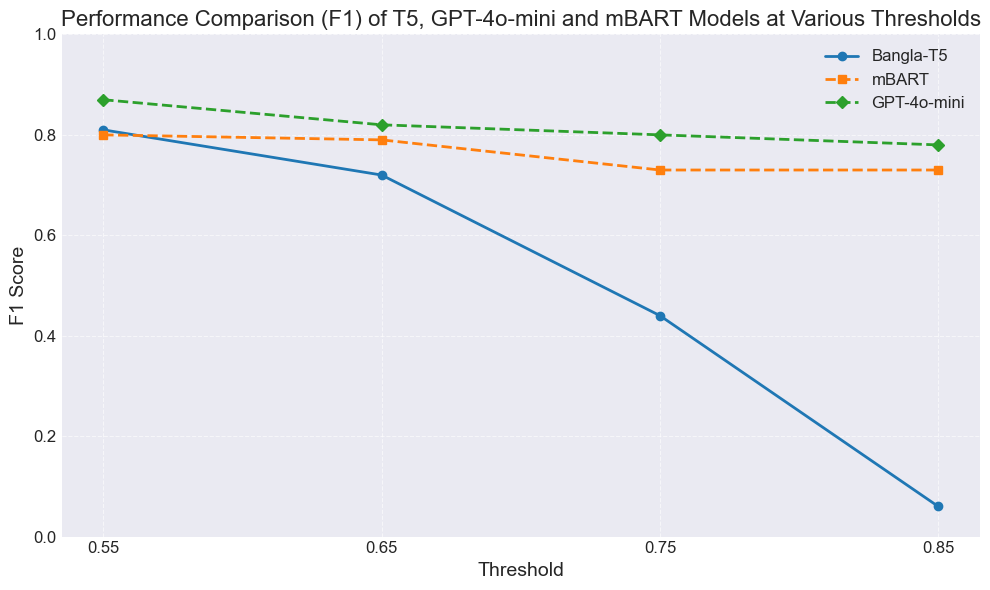

In [42]:
# Re-import libraries after state reset
import matplotlib.pyplot as plt

# Thresholds
thresholds = [0.55, 0.65, 0.75, 0.85]

# F1 scores and BERT scores for T5
t5_f1 = [0.81, 0.72, 0.44, 0.06]
t5_bert = [0.86, 0.86, 0.86, 0.86]

# F1 scores and BERT scores for mBART
mbart_f1 = [0.80, 0.79, 0.73, 0.73]
mbart_bert = [0.75, 0.75, 0.75, 0.75]

# F1 scores and BERT scores for GPT-4o-mini
gpt_f1 = [0.87, 0.82, 0.80, 0.78]
gpt_bert = [0.92, 0.95, 0.94, 0.93]

# Use an available elegant style
plt.style.use('seaborn-v0_8-darkgrid')

# Define colors
t5_color = '#1f77b4'    # blue
mbart_color = '#ff7f0e'  # orange
gpt_color = '#2ca02c'    # bright green

# Plotting F1 scores
plt.figure(figsize=(10, 6))
plt.plot(thresholds, t5_f1, marker='o', linestyle='-', linewidth=2, color=t5_color, label='Bangla-T5')
plt.plot(thresholds, mbart_f1, marker='s', linestyle='--', linewidth=2, color=mbart_color, label='mBART')
plt.plot(thresholds, gpt_f1, marker='D', linestyle='--', linewidth=2, color=gpt_color, label='GPT-4o-mini')

# Labels and title
plt.title('Performance Comparison (F1) of T5, GPT-4o-mini and mBART Models at Various Thresholds', fontsize=16)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(thresholds, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## Plot 01
The plot shows how well three language models—Bangla-T5, mBART, and GPT-4o-mini—perform in detecting plagiarism in Bangla using F1 Scores at different similarity thresholds. As the threshold gets higher (from 0.55 to 0.85), Bangla-T5’s performance drops sharply, meaning it struggles when stricter matching is required. On the other hand, mBART performs steadily, with only a small drop in its scores. GPT-4o-mini gives the best results across all thresholds, staying strong even at high levels. Overall, GPT-4o-mini is the most reliable for finding paraphrased plagiarism, while Bangla-T5 may need improvement to work well in stricter cases.

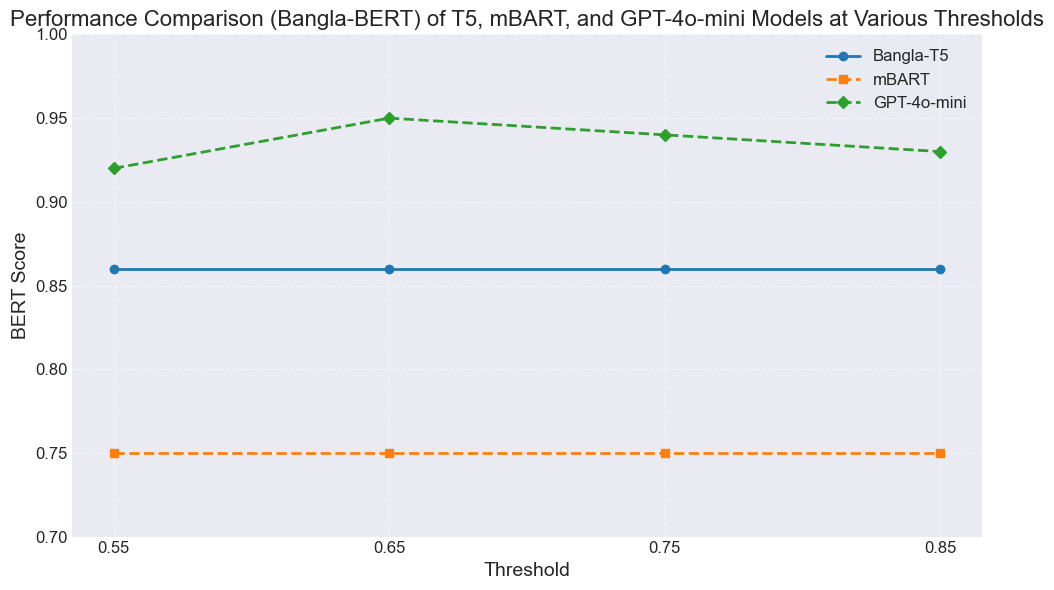

In [45]:
# Plotting BERT scores
plt.figure(figsize=(10, 6))
plt.plot(thresholds, t5_bert, marker='o', linestyle='-', linewidth=2, color=t5_color, label='Bangla-T5')
plt.plot(thresholds, mbart_bert, marker='s', linestyle='--', linewidth=2, color=mbart_color, label='mBART')
plt.plot(thresholds, gpt_bert, marker='D', linestyle='--', linewidth=2, color=gpt_color, label='GPT-4o-mini')

plt.title('Performance Comparison (Bangla-BERT) of T5, mBART, and GPT-4o-mini Models at Various Thresholds', fontsize=16)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('BERT Score', fontsize=14)
plt.xticks(thresholds, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.7, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## Plot 02
This plot shows the Bangla-BERT similarity scores for three language models—Bangla-T5, mBART, and GPT-4o-mini—at different thresholds used for Bangla plagiarism detection. The BERT score measures how semantically close the generated paraphrase is to the reference sentence.

From the plot, we can see that GPT-4o-mini consistently achieves the highest BERT scores, peaking at 0.95 and staying above 0.92 across all thresholds, which indicates strong semantic understanding. Bangla-T5 also performs well, maintaining a steady BERT score of around 0.86. In contrast, mBART has the lowest scores, remaining flat at 0.75 throughout, suggesting weaker semantic similarity in its paraphrases. Overall, GPT-4o-mini demonstrates the best semantic match quality, while mBART lags behind, and Bangla-T5 performs moderately well.

## Conclusion
In conclusion one observation I would like to share is that paraphrase generation did not significantly improve the results in this case. As we know, language models often struggle with low-resource languages like Bangla. However, better performance might be achieved by fine-tuning the language model and experimenting with different types of prompting strategies.